# Tutorial for Vernier Acuity #
<strong> HJ/BW, ISETBIO TEAM, 2015 </strong>

This tutorial script uses biological and computational methods to analyze vernier acuity (super acuity) in human vision.

Vernier acuity (or positional acuity) is a measurement of sensitivity of human eye in detecting mis-alignment of simple object (lines, etc.).

In this script, we compute the irradiance and human cone absorptions for a scene with two mis-aligned lines. Then, we try to discriminate the aligned and mis-aligned cases by using first order statistics and machine learning classifiers

## Initialize path and session

In [1]:
addpath(genpath('~/isetbio'));  % add isetbio to path
ieInit;  % Initialize a new isetbio session

## Create the display

We start with an Sony OLED display that we once calibrated.

In [2]:
dpi = 110;
d = displayCreate('OLED-Sony','dpi',dpi);

viewDist = 0.3;  % Set the subject's viewing distance in meters
d = displaySet(d, 'viewing distance', viewDist);

In general, RGB images are treated as DAC values, not linear RGB. They will be converted into linear RGB by display gamma in vcReadImage line 180. But we want to calculate here with linear RGB.  So we set the table to linear and thus there is no difference between DAC and linear RGB.

In [3]:
d = displaySet(d, 'gtable','linear');

## Create a Vernier scene ##
We create a vernier scene radiance image by specifying a image on a calibrated display. This method makes each of the parameters explicit. This provides flexibility for scripting.

In [4]:
[~, p] = imageVernier();   % Mainly to get the parameters
p.pattern = 0.5*ones(1,33); p.pattern(17) = 1;

% Aligned
p.offset = 0;
imgA = imageVernier(p);

% Misaligned
p.offset = 2;
imgM = imageVernier(p);

Create a scene with the image using the display parameters. The scene spectral radiance is created using the RGB image and the properties of the display.

In [5]:
sceneA = sceneFromFile(imgA, 'rgb', [], d); % aligned
sceneM = sceneFromFile(imgM, 'rgb', [], d); % mis-aligned

Adjust field of view of the scene

In [6]:
fov = size(imgA,2)/displayGet(d,'dots per deg');
sceneA = sceneSet(sceneA,'fov',fov);
sceneM = sceneSet(sceneM,'fov',fov);

## Examine scene properties ##
The scene luminance at the different sample points on the display is as below

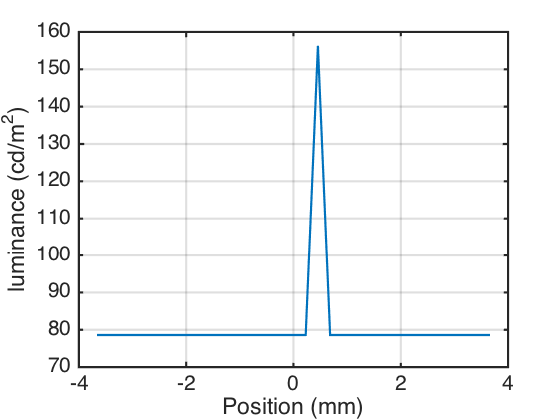

In [7]:
sz = sceneGet(sceneM,'size');
scenePlot(sceneM,'luminance hline',[1,round(sz(1)/2)]);

And the full spectral radiance on the same line

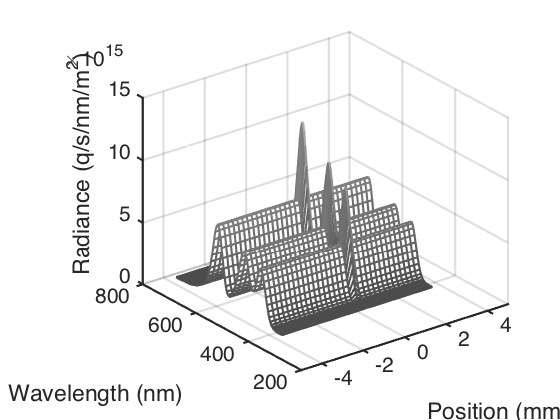

In [15]:
scenePlot(sceneM,'radiance hline',[1,round(sz(1)/2)]);

## Compute Irradiance with Optics Wavefront ##
In this section, we compute the optical image (irradiance map) by using human optics wavefront.
If we just want a standard human optics model, we can simplify the code as oiCraete('wvf human');

In [18]:
%  Load Zernike coefficient
pupilSize = 3; % pupil size in mm
zCoefs = wvfLoadThibosVirtualEyes(pupilSize);

%  Create wavefront structure
wvf = wvfCreate('wave', sceneGet(sceneA, 'wave'), 'zcoeffs', zCoefs, 'name', 'human optics');
wvf = wvfSet(wvf, 'calc pupil size', pupilSize); 

Now, let's adjust optics properties for individuals.
Here, we use defocus as an example. For more adjustable entries, see wvfOSAIndexToVectorIndex

In [19]:
zDefocus = -0.0104; 
wvf = wvfSet(wvf, 'zcoeffs', zDefocus, {'defocus'});

compute psf and convert to optical image structure

In [20]:
wvf = wvfComputePSF(wvf);
oi = wvf2oi(wvf, 'human');
oi = oiSet(oi, 'name', sprintf('Human WVF %.1f mm', pupilSize));

Here's the point spread function at different wavelengths

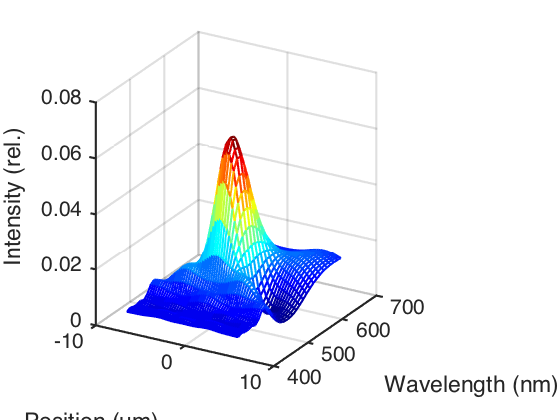

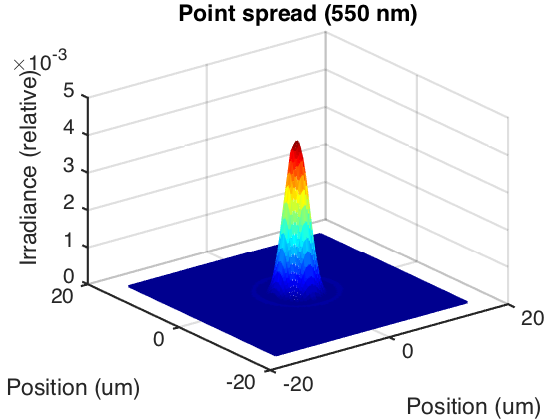

In [21]:
oiPlot(oi,'psf 550');
nPoints = 50;
oiPlot(oi,'ls wavelength',[],nPoints);

Compute irradiance map with command oiCompute:

In [22]:
oiA = oiCompute(sceneA, oi);
oiM = oiCompute(sceneM, oi);

rect = [10    15    81   100];
oiA = oiCrop(oiA,rect);
oiM = oiCrop(oiM,rect);

Another way to do this computation is using the chromatic aberration in the Marimont and Wandell model (1994, JOSA).
You can create that oi structure simply by calling oi = oiCreate('human');

Examine the irradiance at the retina, prior to absorption

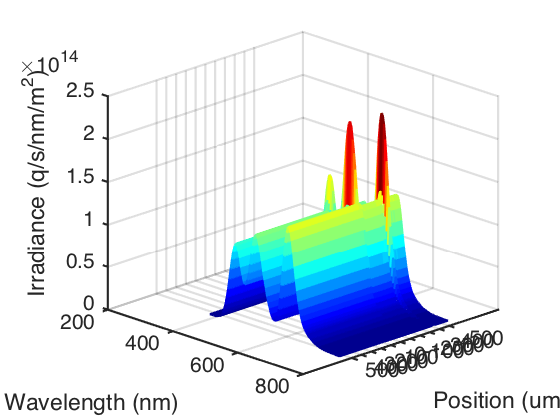

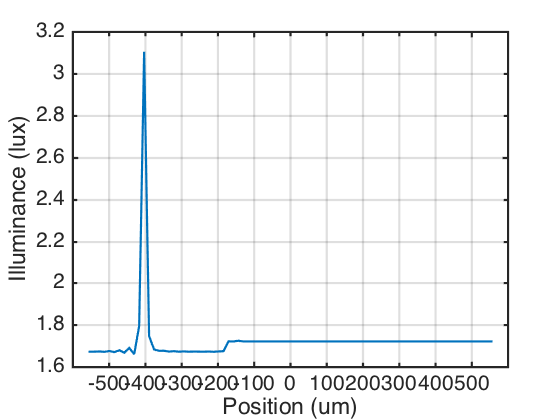

In [25]:
sz = sceneGet(oiA,'size');
oiPlot(oiA,'illuminance hline',[1,round(sz(1)/2)]);

% This is the full spectral radiance on the same line
oiPlot(oiA,'irradiance hline',[1,round(sz(1)/2)]);
view(135,23);

Notice that the short-wavelength light is spread a lot more at the retinal surface than the middle wavelength light.
The long-wavelength is spread a little bit more.

## Compute Photon Absorptions of Human Cone Receptors ##
Compute the human cone absorption samples with fixational eye movement.

In [26]:
cones = sensorCreate('human');
fov = 0.7*sceneGet(sceneA, 'fov');
cones = sensorSetSizeToFOV(cones, fov, sceneA, oiA);
cones = sensorCompute(cones,oiM);

Show the plane cone mosaic (with no absorptions)

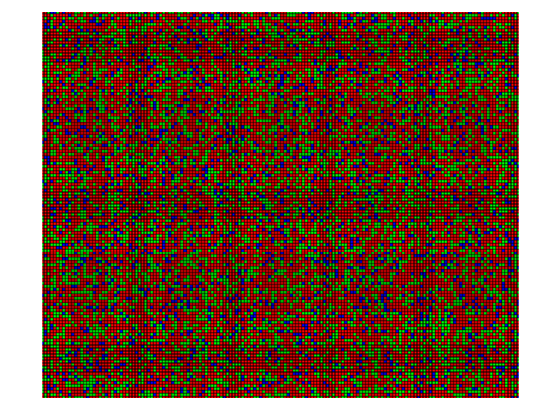

In [28]:
sensorConePlot(cones);

Show the absorptions on the mosaic

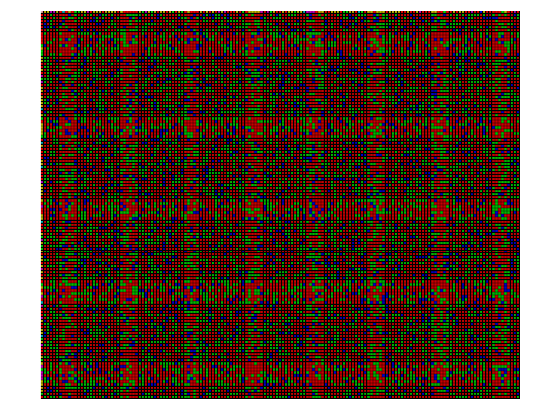

In [29]:
step = 1;
tmp = coneImageActivity(cones,[],step,false);
tmp(:,:,3) = tmp(:,:,3)*2;

vcNewGraphWin;
imagescRGB(tmp);